# NLP Assignment 2
### Paarth Iyer
### MCS202218

In [1]:
from collections import Counter, defaultdict

from nltk import ngrams, word_tokenize, sent_tokenize
from nltk.corpus import stopwords

import scipy
from scipy.sparse import dok_matrix, csr_matrix
from scipy.spatial.distance import euclidean

import numpy as np

import joblib   # saving and loading files
from tqdm import tqdm
import gc

# directory for storing data
stores = "./model/"

# Preprocessing

Same corpus that was used in the previous assignment was used with some additional preprocessing being lemmatization of all the words

# Building vocab

Using the code from previous assignment to count the frequencies of all the words. This will also give the vocabulary.

In [ ]:
# function to generate all the unigrams from the file given
def gen_unigrams(file):
    x = Counter()   # Counter to store unigrams
    with open(file, 'r',encoding="utf-8") as f:
        for line in tqdm(f.readlines()):  # going line by line
             for sent in sent_tokenize(line): # extract sentences from each line
                x.update([i[0] for i in ngrams(word_tokenize(sent), 1)])  # create unigrams and add them to counter
    return x

In [ ]:
# will count frequencies of all the words and will give the vocab
vocab_counts = gen_unigrams("corpus.txt")

100%|██████████| 56528/56528 [25:08<00:00, 37.46it/s]  


In [39]:
# dumping this into a pickle file for future use
joblib.dump(vocab_counts, stores+'corpus_tokens.pickle')

# ['./model/corpus_tokens.pickle']

['./model/corpus_tokens.pickle']

In [85]:
# code block to load the file
vocab_counts = joblib.load(stores+'corpus_tokens.pickle')

In [40]:
# the size of vocab will be the number of entries in vocab_counts
print("Size of vocab is",len(vocab_counts))

Size of vocab is 1976778


Going with a vocab of size around 38k does not give a memory error. I tried to make a matrix with a vocab which has words whose frequency is more than 50, but it ran into a memory error.

In [92]:
# compiling a set of stop words
stp = set(stopwords.words('english') + stopwords.words('german') + stopwords.words('french'))

# creating a new vocab where only the words which are not stopwords and occur more
# than 100 times are considered
vocab = {x for x, count in vocab_counts.items() if count >= 100 and x not in stp}

# dumping the set
joblib.dump(vocab,stores+"vocab.pickle")

['./model/vocab.pickle']

In [89]:
# size of the new generated vocab
print("Size of reduced vocab is",len(vocab))

Size of reduced vocab is 37901


Creating a dictionary which will act as an index, where the keys will be numbers and words where the values are the corresponding word and number respectively.

In [10]:
# this part is used to create an index for the vocab where each word is given a number
# and also a corresponding number for the word 

# number to word
vocab_list = list(vocab.keys())

# corresponding word to number
vocab_pos = {vocab_list[i] : i for i in range(len(vocab_list))}

# compiling both into a dictionary
vocab_idx = vocab_pos.copy()
vocab_idx.update({i : w for i,w in enumerate(vocab_list)})

In [11]:
# dumping th edictionary for future use
joblib.dump(vocab_idx,stores+'vocab_idx.pickle')

['./model/vocab_idx.pickle']

In [12]:
# some cleanup
del vocab_counts
del vocab_list
del vocab_pos
gc.collect()

0

# Building Co-occurance matrix

In [2]:
# loading the index and vocab
vocab_idx = joblib.load(stores+'vocab_idx.pickle')
vocab = joblib.load(stores+'vocab.pickle')

The function below returns a co-occurance matrix, which is in the format of a compressed sparse row matrix (scipy csr matrix).

It will first create a defaultdict of counters, which will keep track of co-occurances where the ith index of the defaultdict corresponds to a counter which acts as a sparse vector of the word at the ith index.

Then it creates an empty dok matrix and populates it the entries in the above defaultdict.

Finally, it converts the dok matrix to a csr matrix and returns it.

In [41]:
def co_occurances(file):
    window = 10

    # creates a ramp given a window size
    ramp = [0] + [*range(window,0,-1)]     # ramp = [0,10,9,8,7,6,4,3,2,1]

    # keeps track of co-occurances
    occurances = defaultdict(lambda : Counter())

    with open(file, 'r',encoding="utf-8") as corpus:

        # iterate through all the lines (each line corresponds to one article)
        for line in tqdm(corpus.readlines()):

            # list of all n-grams in the line, where n = window+1. Added padding so that all the possible
            # co-occurances are listed
            all_grams = ngrams(word_tokenize(line), window+1, pad_right = True, pad_left = True)
            
            # going through each n-gram
            for grams in all_grams:

                # will proceed only if gram[0] is in the vocab.
                # non vocab words are not removed so that the vocab words don't clump together
                if grams[0] in vocab :
                    for idx, gram in enumerate(grams):
                        if gram in vocab:
                            # increase the co-occurance according to the distance between the words
                            occurances[vocab_idx[grams[0]]][vocab_idx[gram]] += ramp[idx]

                # Doing the same as above with the gram reversed
                grams_rev = grams[::-1]

                if grams_rev[0] in vocab:
                    for idx, gram in enumerate(grams_rev):
                        if gram in vocab:
                            occurances[vocab_idx[grams_rev[0]]][vocab_idx[gram]] += ramp[idx]

    # create an empty sparse matrix
    mat = dok_matrix((len(vocab), len(vocab)), dtype=np.int64)

    # populate the matrix
    for i in tqdm(range(len(vocab))):
        for j in occurances[i].keys():
            mat[i,j] = occurances[i][j]

    # convert to csr matrix and return it
    return mat.tocsr()

In [1]:
halmat = co_occurances("corpus.txt")

100%|██████████| 37901/37901 [14:33<00:00, 43.37it/s] 


In [9]:
# dump for future use
joblib.dump(halmat,stores+"vec_matrix.pickle")

In [3]:
halmat = joblib.load(stores+'vec_matrix.pickle')

In [5]:
# Given two words, take their index, take those rows from the sparse matrix, 
# convert that into an array and flatten it. Then normalize those and take 
# the euclidean distance between those two vectors
def word_dist(x, y):
    a1 = halmat[vocab_idx[x],:].toarray().flatten()
    a2 = halmat[vocab_idx[y],:].toarray().flatten()
    return euclidean(a1/np.linalg.norm(a1), a2/np.linalg.norm(a2))

In [6]:
# an example
word_dist('dog', 'horse')

0.2996810886398755

This function will find the k closest words to the given word. 

The norms of all the vectors are pre calculated

It calculates the vector of the given word and then loops through all the words in the vocab, create their vectors and find the distance and add that to a dist list along with the word. 

Then we sort the list with the distance and return the top k elements remopving the first one (as that will be the word itself)

In [4]:
# precomputing the norms of all the vectors
norms = [(lambda x: np.linalg.norm(halmat[x,:].toarray().flatten()))(x) for x in range(len(vocab))]

def closest_words(x, k=10):
    a1 = halmat[vocab_idx[x],:].toarray().flatten()
    a1 = a1/norms[vocab_idx[x]]  # vector of the target word

    dists = [(i, euclidean(a1, halmat[vocab_idx[i],:].toarray().flatten()/norms[vocab_idx[i]])) for i in tqdm(vocab)]

    dists.sort(key= lambda x:x[1])

    return dists[1:(k+1)]

In [5]:
# some more imports for the plot

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from adjustText import adjust_text


### Functions to output the table and plot

In [6]:
# A function to format the similar words and print the results in a table
def print_similar(similar):

    max_len = max(len(max(np.array(similar).flatten(), key = len)), 12)

    # creating column names
    col_names = ['Target'] + ['n'+str(i) for i in range(1,len(similar[0]))]

    # formatting and printing them so that the names are centered
    print(("| {:^{maxl}} "*len(col_names)+"|").format(*col_names, maxl=max_len))

    # The seperator
    seperator = ("+-{:^{maxl}}-"*len(col_names)+"+").format(*["-"*max_len for _ in range(len(col_names))], maxl = max_len)
    print(seperator)

    for ws in similar:
        # formatting and printing each list
        print(("| {:<{maxl}} "*len(col_names)+"|").format(*ws, maxl = max_len))
        print(seperator)

In [7]:
# will plot the list of lists of the similar words to the nouns
def plot_similar(sim):

    # some initializations
    k = len(sim[0])
    num_clusters = len(sim)
    sim = np.array(sim).flatten()

    # list of word vectors for all the words in the similar list
    pts = np.array([(lambda a2:a2/np.linalg.norm(a2))(halmat[vocab_idx[w],:].toarray().flatten()) for w in sim])

    # Applying t-SNE with the perplexity set to the number of words in 'nouns' 
    pts_emb = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=num_clusters).fit_transform(pts)

    # Taking transpose of the above
    pts_emb = [list(i) for i in zip(*pts_emb)]
    X = pts_emb[0];Y = pts_emb[1]

    # Generating num_clusters number of random colours
    clrs = [np.random.random(3) for _ in range(num_clusters)]
    clrs = sum([[x]*k for x in clrs],[])  # Expanding to give colour to each point

    plt.figure(figsize=(8,6), dpi=120)

    plt.scatter(X,Y, s= 10,c = np.array(clrs))
    plt.axis('off')

    # Adding label to each point
    texts = [plt.text(X[i], Y[i], txt, size = 6.5) for i, txt in enumerate(sim)]
    adjust_text(texts) # Adjust text to make it readable


# Results

The nouns picked : 

In [25]:
nouns = ['bread', 'monitor', 'chicken', 'ibuprofen']

Computing the similar words and putting them in a list of list of similar words, where the first word is the target word

In [26]:
similar = []
for w in nouns:
    similar.append([w]+[x for x,_ in closest_words(w, k=5)])

100%|██████████| 37901/37901 [00:08<00:00, 4440.40it/s]


|    Target     |      n1       |      n2       |      n3       |      n4       |      n5       |      n6       |      n7       |      n8       |      n9       |      n10      |
+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| bread         | grain         | cereal        | cook          | meat          | eat           | food          | beer          | rice          | flavor        | berry         |
+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| monitor       | monitoring    | evaluation    | track         | appropriate   | measure       | whilst        | follow        | initially     | instead       | treatment     |
+---------------+---------------+---------------+---------------+---------------+---------------+-------------

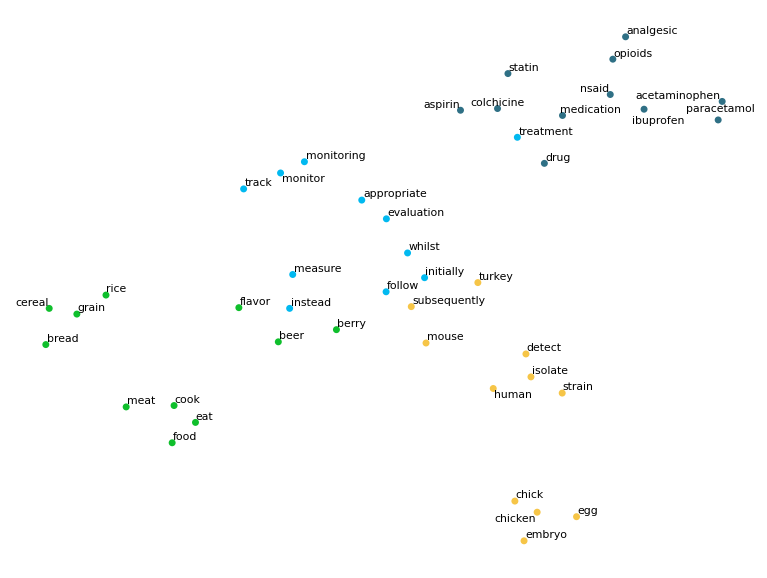

In [29]:
print_similar(similar)
plot_similar(similar)

The words picked, titanium, keyboard, delhi and dog, have the shown similar words.

When they are plotted, it can be seen that the words similar to delhi, which are locations, cluster together far away from other points. 

Similarly, the words similar to dog, which are animal related, cluster together away from other points.

The clusters formed by the words siilar to titanium and keyboard are close together, as they both relate to technology and technological terms.